In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import sys
sys.path.append('../../../utils')

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

pip install 'aif360[AdversarialDebiasing]'


### Read modelling dataset

In [2]:
dataset = pd.read_csv('../../data/modelling-dataset.csv')

In [3]:
dataset.iloc[:,0]

0          863.97
1          828.63
2         1000.59
3          700.42
4          505.92
           ...   
181897    1949.28
181898    2096.72
181899    2134.48
181900    2538.29
181901    3799.74
Name: current_premium, Length: 181902, dtype: float64

In [4]:
orig_dataset = BinaryLabelDataset(df=dataset, label_names=['risk_group'],
                                  protected_attribute_names=['male', 'middle-aged', 'ypc_1', 'minority'],
                                  favorable_label=0, unfavorable_label=1)

In [5]:
# check whether it's resampled
df_og = orig_dataset.convert_to_dataframe()[0]
df_og['risk_group'].value_counts()

1.0    90951
0.0    90951
Name: risk_group, dtype: int64

In [49]:
# 70:30 split into train, test
# 50:50 split of test into valid, test
dataset_train, dataset_vt = orig_dataset.split([0.7], shuffle=True)
dataset_valid, dataset_test = dataset_vt.split([0.5], shuffle=True)

### Modelling: Logistic

#### Train

In [50]:
scale_orig = StandardScaler()

# scale values, setup training data
X_train = scale_orig.fit_transform(dataset_train.features)
y_train = dataset_train.labels.ravel()
w_train = dataset_train.instance_weights.ravel()

# train logistic model
logreg = LogisticRegression().fit(X_train, y_train, sample_weight=w_train)
y_train_pred = logreg.predict(X_train) #this seems wrong

In [51]:
# dataset_train --> dataset_train_pred
dataset_train_pred = dataset_train.copy()
dataset_train_pred.labels = y_train_pred

In [52]:
# accuracy score
(y_train_pred == y_train).sum()/len(y_train)

0.9629705256379043

#### Valid

In [53]:
# dataset_valid --> dataset_valid_pred
dataset_valid_pred = dataset_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_valid_pred.features)
y_valid = dataset_valid_pred.labels

# get preds for obs being in risk group 1
pos_ind = 1
dataset_valid_pred.scores = logreg.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
y_valid_pred = dataset_valid_pred.scores

In [54]:
def find_metrics(labels, preds, thresh=None, print_results=True):
    if thresh == None:
        thresh = np.mean(labels)
    
    y_preds = np.where(preds > thresh, 1, 0)
    
    bal_acc = balanced_accuracy_score(labels, y_preds)
    acc = accuracy_score(labels, y_preds)
    prec_score = precision_score(labels, y_preds)
    rec_score = recall_score(labels, y_preds)
    
    if print_results:
        print("The mean threshold of the model is %f " % (thresh))
        print("The accuracy score of the model is %s" % acc)
        print("The balanced accuracy score of the model is %s" % bal_acc)
        print("Precision: %s" % prec_score)
        print("Recall: %s" % rec_score)
    
    return bal_acc, thresh

In [55]:
find_metrics(y_valid, y_valid_pred)

The mean threshold of the model is 0.502950 
The accuracy score of the model is 0.9620670698185816
The balanced accuracy score of the model is 0.9618419112225336
Precision: 0.9298685458734246
Recall: 1.0


(0.9618419112225336, 0.5029503390141103)

#### Test

In [56]:
# dataset_test --> dataset_test_pred
dataset_test_pred = dataset_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_test_pred.features)
y_test = dataset_test_pred.labels

# get preds for obs being in risk group 1
pos_ind = 1
dataset_test_pred.scores = logreg.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
y_test_pred = dataset_test_pred.scores

In [57]:
find_metrics(y_test, y_test_pred)

The mean threshold of the model is 0.500440 
The accuracy score of the model is 0.9617386205380049
The balanced accuracy score of the model is 0.9617049372753284
Precision: 0.9289747601877679
Recall: 1.0


(0.9617049372753284, 0.5004397859708275)

### Find optimal classification threshold for logistic model

#### Valid dataset

In [59]:
# sklearn metrics
num_thresh = 100
ba_arr_skl = np.zeros(num_thresh)
thresh_arr_skl = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    ba_arr_skl[idx], thresh_arr_skl[idx] = find_metrics(y_valid, y_valid_pred, thresh=class_thresh, print_results=False)
    
best_ind_skl = np.where(ba_arr_skl == np.max(ba_arr_skl))[0][0]
best_class_thresh = class_thresh_arr[best_ind_skl]

print("Best balanced accuracy = %.4f" % np.max(ba_arr_skl))
print("Optimal classification threshold = %.4f" % best_class_thresh)

Best balanced accuracy = 0.9658
Optimal classification threshold = 0.5940


In [60]:
# labels = ['TN' ,'FP' ,'FN' ,'TP']
# categories = ['0', '1']
# thresh = np.mean(y_test)

# cm = confusion_matrix(y_test, np.where(y_test_pred > thresh, 1, 0).ravel())
# arr = np.array(cm)

# make_confusion_matrix(arr, group_names=labels, categories=categories, figsize=(5,5), sum_stats=True)

In [61]:
privileged_groups = [{'male': 0, 'middle-aged': 0, 'minority': 0, 'ypc_1': 0}]
unprivileged_groups = [{'male': 1, 'middle-aged': 1, 'minority': 1, 'ypc_1': 1}]

# select datasets
d1 = dataset_valid
d2 = dataset_valid_pred

In [67]:
# aif360 metrics
num_thresh = 100
ba_arr = np.zeros(num_thresh)
thresh_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    # labels = y_test, scores = y_preds
    unfav_inds = d2.scores > class_thresh
    d2.labels[unfav_inds] = d2.unfavorable_label
    d2.labels[~unfav_inds] = d2.favorable_label

    metrics_valid = ClassificationMetric(d1, d2, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

    thresh_arr[idx] = class_thresh
    ba_arr[idx] = 0.5*(metrics_valid.true_positive_rate()+metrics_valid.true_negative_rate())
    
# best threshold is where accuracy is max
best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Step 1: Baseline (no reweighing)")
print("------------------------------------------")
print("Best balanced accuracy = %.6f" % np.max(ba_arr))
print("Optimal classification threshold = %.4f" % best_class_thresh)

Step 1: Baseline (no reweighing)
------------------------------------------
Best balanced accuracy = 0.965766
Optimal classification threshold = 0.5940


### Train on transformed data

In [68]:
dataset_transf = pd.read_csv('../../data/allstate-transformed.csv')

In [69]:
dataset_transf = BinaryLabelDataset(df=dataset_transf, label_names=['risk_group'], 
                             protected_attribute_names=['male', 'middle-aged', 'ypc_1', 'minority'],
                             favorable_label=0, unfavorable_label=1)

In [70]:
# 70:30 split into train, test
# 50:50 split of test into valid, test
dataset_transf_train, dataset_transf_vt = dataset_transf.split([0.7], shuffle=True)
dataset_transf_valid, dataset_transf_test = dataset_transf_vt.split([0.5], shuffle=True)

#### Train

In [71]:
scale_transf = StandardScaler()
X_train_transf = scale_transf.fit_transform(dataset_transf_train.features)
y_train_transf = dataset_transf_train.labels.ravel()
w_train_transf = dataset_transf_train.instance_weights.ravel()

logreg = LogisticRegression().fit(X_train_transf, y_train_transf, sample_weight=w_train_transf)
y_train_pred = logreg.predict(X_train_transf)

#### Valid

In [74]:
dataset_transf_valid_pred = dataset_transf_valid.copy(deepcopy=True)

X_valid_transf = scale_transf.fit_transform(dataset_transf_valid_pred.features)
y_valid_transf = dataset_transf_valid_pred.labels

# prob of predicting obs to be in risk group 1
pos_ind = 1
dataset_transf_valid_pred.scores = logreg.predict_proba(X_valid_transf)[:,pos_ind].reshape(-1,1)
y_valid_preds_transf = dataset_transf_valid_pred.scores

In [76]:
find_metrics(y_valid_transf, y_valid_preds_transf)

The mean threshold of the model is 0.501204 
The accuracy score of the model is 0.9652879581151832
The balanced accuracy score of the model is 0.9652041566075364
Precision: 0.9352286049237983
Recall: 1.0


(0.9652041566075364, 0.5012041884816754)

#### Test

In [77]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)

X_test_transf = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test_transf = dataset_transf_test_pred.labels

# prob of predicting obs to be in risk group 1
pos_ind = 1
dataset_transf_test_pred.scores = logreg.predict_proba(X_test_transf)[:,pos_ind].reshape(-1,1)
y_test_preds_transf = dataset_transf_test_pred.scores

In [78]:
find_metrics(y_test_transf, y_test_preds_transf)

The mean threshold of the model is 0.503141 
The accuracy score of the model is 0.9635078534031414
The balanced accuracy score of the model is 0.963277133825079
Precision: 0.9323760551081789
Recall: 1.0


(0.963277133825079, 0.5031413612565445)

In [79]:
# thresh = np.mean(y_test)

# # tn, fp, fn, tp
# cm = confusion_matrix(y_test, np.where(y_preds_test > thresh, 1, 0).ravel())
# arr = np.array(cm)

# labels = ['TN' ,'FP' ,'FN' ,'TP']
# categories = ['0', '1']

# make_confusion_matrix(arr, group_names=labels, categories=categories, figsize=(5,5))

## Tradeoffs

### Compute fairness metrics at optimal classification threshold

In [80]:
from IPython.display import Markdown, display
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [82]:
# select datasets
d1 = dataset_test
d2 = dataset_test_pred

In [83]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr = []
mean_diff_arr = []
avg_odds_arr = []
disp_imp_arr = []
indiv_fair_arr = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    unfav_inds = d2.scores > thresh
    d2.labels[unfav_inds] = d2.unfavorable_label
    d2.labels[~unfav_inds] = d2.favorable_label
    
    metrics_test = ClassificationMetric(d1, d2,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(metrics_test.true_positive_rate()+metrics_test.true_negative_rate())
    bal_acc_arr.append(bal_acc)
    
    mean_diff_arr.append(metrics_test.mean_difference())    
    avg_odds_arr.append(metrics_test.average_odds_difference())
    disp_imp_arr.append(metrics_test.disparate_impact())
    indiv_fair_arr.append(metrics_test.consistency(n_neighbors=5))

#### Predictions from original testing data

  0%|          | 0/100 [00:00<?, ?it/s]

Classification threshold used = 0.5940


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


### Transformed dataset

In [84]:
# select datasets
d1 = dataset_transf_test
d2 = dataset_transf_test_pred

In [85]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
mean_diff_arr_transf = []
avg_odds_arr_transf = []
disp_imp_arr_transf = []
indiv_fair_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    unfav_inds = d2.scores > thresh
        
    # broadcast labels
    d2.labels[unfav_inds] = d2.unfavorable_label
    d2.labels[~unfav_inds] = d2.favorable_label
    
    metrics_test_transf = ClassificationMetric(d1, d2, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

    bal_acc = 0.5*(metrics_test_transf.true_positive_rate()+metrics_test_transf.true_negative_rate())
    bal_acc_arr_transf.append(bal_acc)

    mean_diff_arr_transf.append(metrics_test_transf.mean_difference())
    avg_odds_arr_transf.append(metrics_test_transf.average_odds_difference())
    disp_imp_arr_transf.append(metrics_test_transf.disparate_impact())
    indiv_fair_arr_transf.append(metrics_test_transf.consistency(n_neighbors=5))

#### Predictions from transformed testing data

  0%|          | 0/100 [00:00<?, ?it/s]

Classification threshold used = 0.5940


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


### Visualize tradeoffs

In [86]:
sns.set()

In [87]:
def plot_tradeoffs(thresholds_array, accuracy_array, fairness_array, transformed_fairness_array, ax, name):
    ax.plot(thresholds_array, accuracy_array)
    ax.set_xlabel('Classification Thresholds', fontsize=10.5)
    ax.set_ylabel('Balanced Accuracy', color='b', fontsize=12, labelpad=15)
    # best_class_thresh used as global variable
    ax.axvline(best_class_thresh, color='k', linestyle=':')

    ax1 = ax.twinx()
    ax1.plot(thresholds_array, fairness_array, color='r', alpha=0.5)
    ax1.set_ylabel(name, color='r', fontsize=12, rotation=-90, labelpad=15)
    ax1.plot(thresholds_array, transformed_fairness_array, color='r')
    
    ax.set_title(name, fontsize=16)
    ax1.legend(['Original', 'Transformed'], loc='lower left')
    ax1.grid(True)

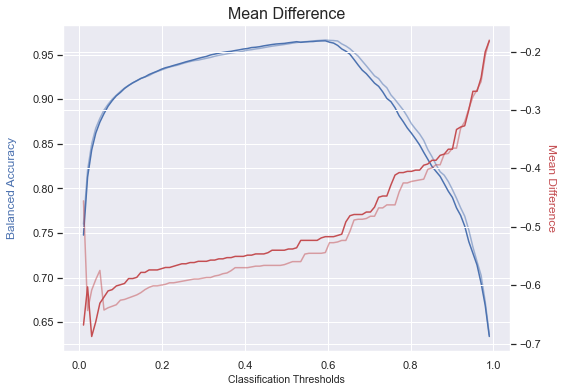

In [88]:
fig, ax = plt.subplots(figsize=(8,6))

name = 'Mean Difference'

ax.plot(class_thresh_arr, bal_acc_arr, color='b', alpha=0.5)
ax.set_xlabel('Classification Thresholds', fontsize=10.5)
ax.set_ylabel('Balanced Accuracy', color='b', fontsize=12, labelpad=15)
ax.plot(class_thresh_arr, bal_acc_arr_transf, color='b')
# best_class_thresh used as global variable
# ax.axvline(best_class_thresh, color='k', linestyle=':')

ax1 = ax.twinx()
ax1.plot(class_thresh_arr, mean_diff_arr, color='r', alpha=0.5)
ax1.plot(class_thresh_arr, mean_diff_arr_transf, color='r')
ax1.set_ylabel(name, color='r', fontsize=12, rotation=-90, labelpad=15)

ax.set_title(name, fontsize=16)
ax1.grid(True)

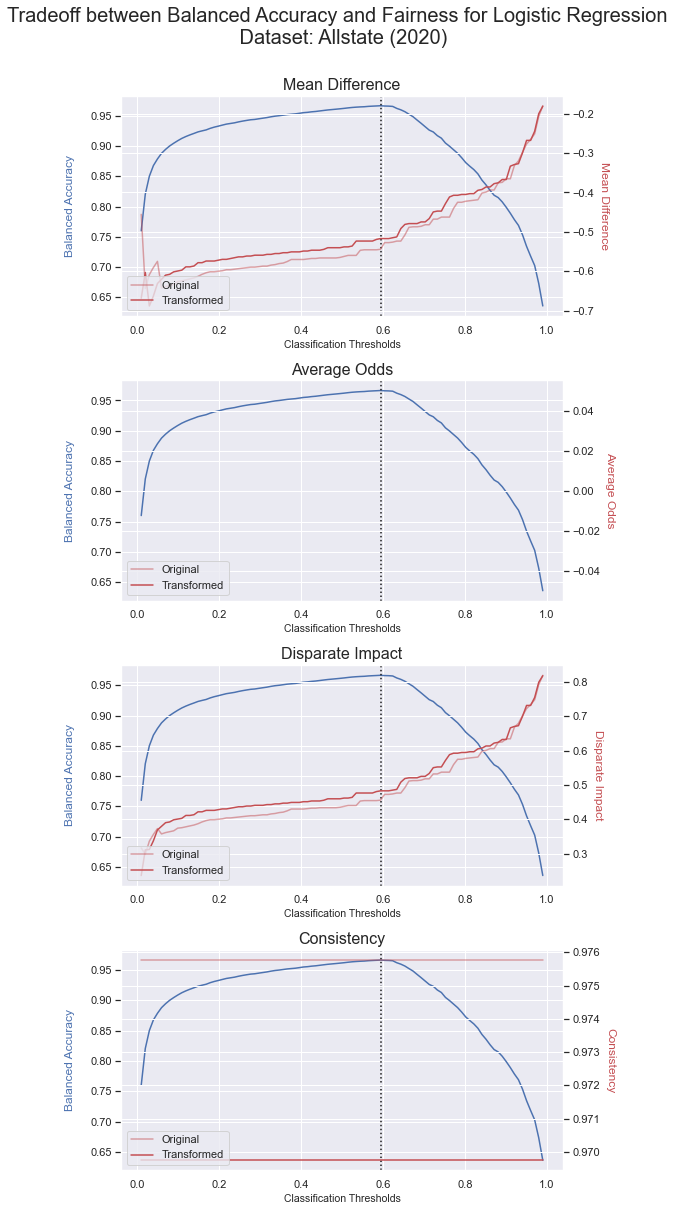

In [89]:
fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(8,16))

plot_tradeoffs(class_thresh_arr, bal_acc_arr, mean_diff_arr, mean_diff_arr_transf, ax=ax[0], name='Mean Difference')

plot_tradeoffs(class_thresh_arr, bal_acc_arr, avg_odds_arr, avg_odds_arr_transf, ax=ax[1], name='Average Odds')

plot_tradeoffs(class_thresh_arr, bal_acc_arr, disp_imp_arr, disp_imp_arr_transf, ax=ax[2], name='Disparate Impact')

plot_tradeoffs(class_thresh_arr, bal_acc_arr, indiv_fair_arr, indiv_fair_arr_transf, ax=ax[3], name='Consistency')

fig.tight_layout()
# fig.subplots_adjust(hspace=0.25)
fig.suptitle('Tradeoff between Balanced Accuracy and Fairness for Logistic Regression \n Dataset: Allstate (2020)', 
             x=0.5, y=1.05, size=20)
plt.show()